In [1]:
import pymolpro as pmp
import os
import numpy as np
import pandas as pd
import math



def orbitalsize(orbital):
    return math.sqrt(sum([orbital.local_second_moments[i][i] for i in range(3)]))

In [2]:
elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar']
# Create the dictionary
geo_dt = {elements[i]: f'{i - 1}' for i in range(len(elements))}
geo_dt.update({'Ca':'18'})
# Print the dictionary
for element, value in geo_dt.items():
    print(f"{element}: {value}")

H: -1
He: 0
Li: 1
Be: 2
B: 3
C: 4
N: 5
O: 6
F: 7
Ne: 8
Na: 9
Mg: 10
Al: 11
Si: 12
P: 13
S: 14
Cl: 15
Ar: 16
Ca: 18


In [18]:

p_list=[]
for k,v in geo_dt.items():
    p=pmp.Project(f'{k}')
    p.write_input(f"""
    geometry={{{k}}}
    basis, cc-pCvDZ
    set, charge={v}
    rhf
    {{CCSD;core,0}}
    put, xml
    """)
    p.run(wait=True)
    p_list.append(p)
    print(k)

H
He
Li
Be
B
C
N
O
F
Ne
Na
Mg
Al
Si
P
S
Cl
Ar
Ca


In [7]:
p_list=[]
for k,v in geo_dt.items():
    p=pmp.Project(f'{k}')
    p_list.append(p)

H
0.47621607970834406
He
0.9273741036181588
Li
1.4982975796877211
Be
2.076664991391323
B
2.6535265780102555
C
3.2298723717695954
N
3.805942267091695
O
4.3821235065953426
F
4.958139258682379
Ne
5.534080661285105
Na
6.097987111556977
Mg
6.689231673321785
Al
7.266406313536928
Si
7.844824337411313
P
8.42292866003188
S
9.000856554667893
Cl
9.578636763276815
Ar
10.156305333590009
Ca
11.258870484500749


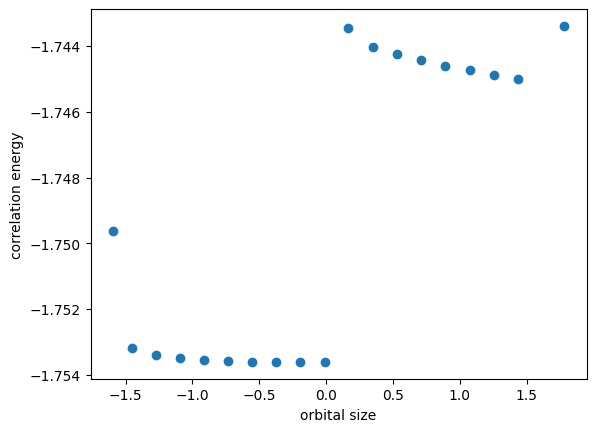

<Figure size 640x480 with 0 Axes>

In [9]:
size_list=[]
corr_list=[]
energy_list=[]
weird=[]
for p in p_list:
    print(p.name)
    for orbital in p.orbitals():
        size_list.append(1/orbitalsize(orbital))
        print(size_list[-1])
        energy_list.append(float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]))
        weird.append(math.log10(abs(energy_list[-1])/size_list[-1]**3))
    #there's only a single pair with two entries
    e=0
    for pair in p.xpath('//pair'):
        tmp=pmp.element_to_dict(pair)
        e=e+float(tmp['energy'])
    
    corr_list.append(e)

mean = np.mean(size_list)
std = np.std(size_list)
normalised=[(i-mean)/std for i in size_list]

cmean = np.mean(corr_list)
cstd = np.std(corr_list)
cnormalised=[(i-mean)/std for i in corr_list]
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.scatter(normalised,cnormalised)
plt.xlabel('orbital size')
plt.ylabel('correlation energy')
plt.show()
plt.savefig('sizeenergy2elec.png')

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0130
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0013  
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 0.0010  
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.0122
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0561
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.1533
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.1637
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.0553
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.0029
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 7.4801e-05
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 4.0965e-04
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 9.5917e-05
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 1.1954e-04
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 1.1362e-04
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━

2024-07-30 19:14:28.516377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


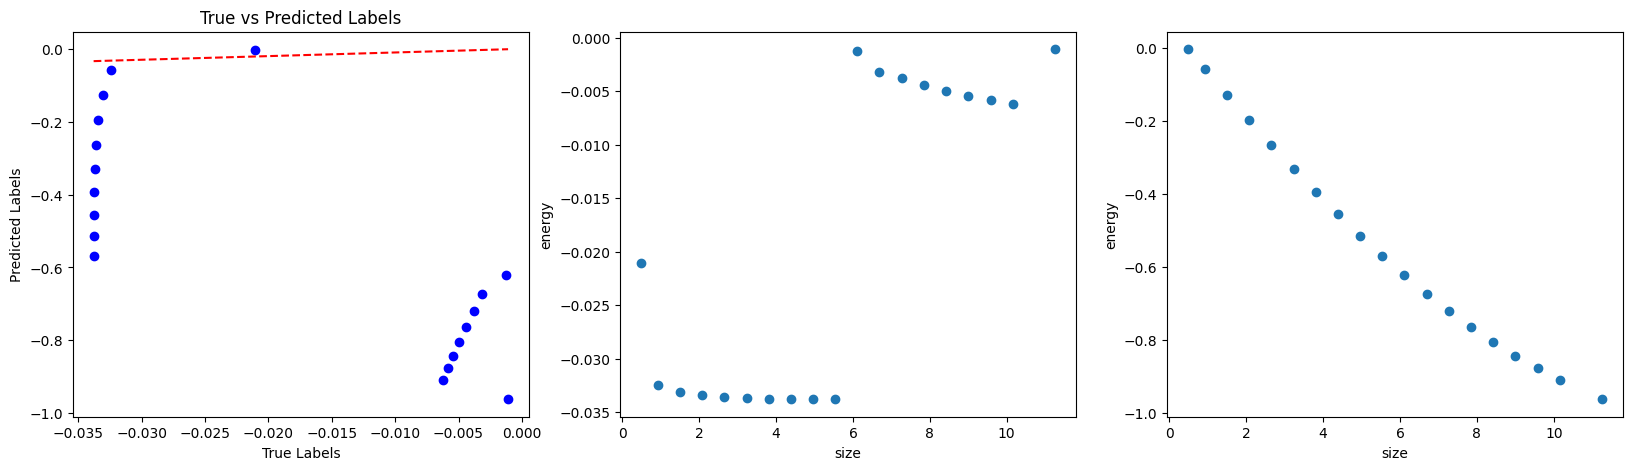

In [25]:
import tensorflow as tf
import keras



batch_size=15

features=np.array(size_list)
features=np.reshape(features,(len(corr_list),1))
labels=np.array(corr_list)
labels=np.reshape(labels,(len(corr_list),1))

mean = np.mean(features)
std = np.std(features)
features = (features - mean) / std

dataset=tf.data.Dataset.from_tensor_slices((features,labels))




model=keras.Sequential([
    keras.layers.Input(shape=(1,)),
    keras.layers.Dense(500,activation='tanh'),
    keras.layers.Dense(1,activation='linear')
])

model.compile('Adam',loss='mse')
model.fit(dataset,epochs=50)


model.save('size.keras')

predictions = model.predict(np.array(size_list))


import matplotlib as mpl
import matplotlib.pyplot as plt

test_labels = []
for features, labels in dataset:
    test_labels.append(labels.numpy())
error=sum([abs((predictions[i]-test_labels[i])/test_labels[i])for i in range(len(predictions))])
print(error)
test_labels = np.concatenate(test_labels, axis=0)
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].scatter(test_labels, predictions, c='blue')
ax[0].plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')  # Line for y=x
ax[0].set_xlabel('True Labels')
ax[0].set_ylabel('Predicted Labels')
ax[0].set_title('True vs Predicted Labels')

ax[1].scatter(size_list,corr_list)
ax[1].set_xlabel('size')
ax[1].set_ylabel('energy')

ax[2].scatter(size_list,predictions)
ax[2].set_xlabel('size')
ax[2].set_ylabel('energy')
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')

In [ ]:
#problems
#discontinuous/jumping graph.
    #decision tree to place the region of the graph then at the leaf use a second method to calculate exact energy.
    #i.e. H--Tree-->output=0 output 0 goes to model 0
    # P--Tree--> output= 2 goes to model 2 for prediction
    #this kinda implies that as we scale up to molecules, this would still matter
    #so trees to categorise the "strength" category of correlation --> orbital size
    #ANN to inteperpolate the category
    #what even the heck would be defining these categories though? from the atom example it seems
    #lets give it a go anyway worse that happens I waste some time.

In [21]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf 
import numpy as np

model_1 = tfdf.keras.DecisionForestModel(verbose=2, check_dataset=False)


model_1.fit(dataset)

# Predict initial categorization
initial_categories = model_1.predict(dataset)

print(model_1.summary())

AttributeError: module 'tensorflow_decision_forests.keras' has no attribute 'DecisionForestModel'

In [26]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()


AttributeError: 'NoneType' object has no attribute 'compile'

In [29]:
from tfx_bsl import KMeans
n_clusters = 3
kmeans = KMeans(num_clusters=n_clusters)
kmeans.train(size_list)
clusters = kmeans.predict(size_list)

def create_model():
    model = tf.keras.Sequential([
        keras.layers.Dense(100, activation='tanh', input_shape=(1,)),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

models={}

for i in range(n_clusters):
    mask = clusters == i
    X_cluster, y_cluster = X[mask], y[mask]
    model = create_model()
    model.fit(X_cluster, y_cluster, epochs=100, verbose=0)
    models[i] = model
    
def predict_correlation_energy(orbital_size):
    normalized_size = normalize(tf.constant([orbital_size]))
    cluster = kmeans.predict(normalized_size)[0]
    return models[int(cluster)].predict([orbital_size])[0][0]

orbital_size = 5.0
predicted_energy = predict_correlation_energy(orbital_size)
print(f"Predicted correlation energy for orbital size {orbital_size}: {predicted_energy}")

ImportError: cannot import name 'KMeans' from 'tfx_bsl' (/home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/tfx_bsl/__init__.py)

2024-08-03 18:43:34.576902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 18:43:34.577039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 18:43:34.839087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 18:43:35.515887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 18:43:40.928714: W tensorflow/compiler/tf2

Epoch 1/10


ValueError: in user code:

    File "/home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=True
      • mask=None


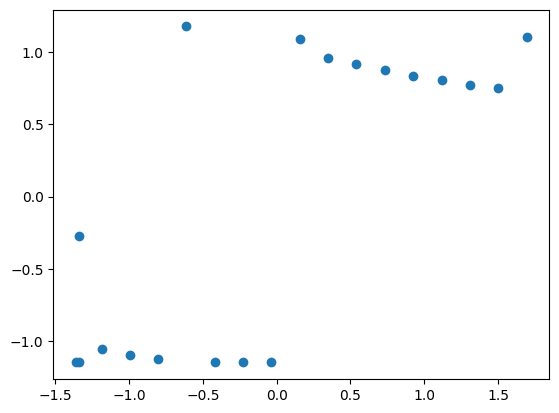

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
data = np.array(list(zip(size_list, corr_list)))
data_scaled=StandardScaler().fit_transform(data)






plt.scatter(data_scaled[:,0],data_scaled[:,1])

model=tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])
model.compile('adam',loss='mse')
model.fit(data_scaled[:,0],data_scaled[:,1],epochs=10)

predictions=model.predict(size_scaled)
predictions_new = StandardScaler.inverse_transform(predictions)


Silhouette Score for 3 clusters: 0.7382589597529207


Text(0.5, 1.0, 'KMeans Clustering with 3 Clusters')

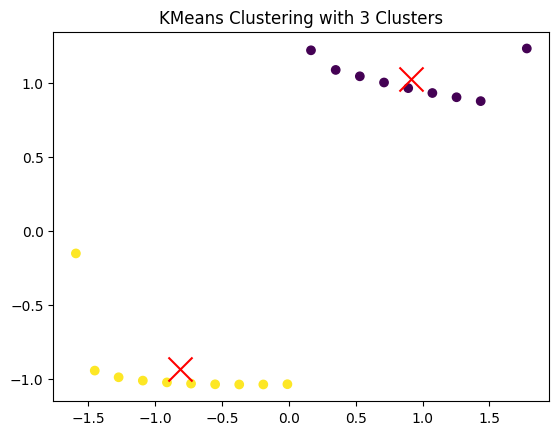

In [37]:
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_scaled)

score = silhouette_score(data_scaled, kmeans.labels_)
print(f'Silhouette Score for 3 clusters: {score}')


labels = kmeans.labels_
plt.scatter(data_scaled[:, 0], data_scaled[: ,1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title(f'KMeans Clustering with 3 Clusters')
print(labels)

In [ ]:

model_1=keras.Sequential([
    keras.layers.Dense(48, activation='tanh')
    keras.layers.Dense(1)
])


model_2=keras.Sequential([
    keras.layers.Dense(48, activation='tanh')
    keras.layers.Dense(1)
])
